<h1 align='center'> Challenge Presentation </h1>

<div align='center'>
<img src="..\..\01_aux_files\img\UK_Traffic_Data\1.png" height='20%' width='20%'/>
<img src="..\..\01_aux_files\img\UK_Traffic_Data\2.png" height='20%' width='20%'/>
<img src="..\..\01_aux_files\img\UK_Traffic_Data\3.png" height='20%' width='20%'/>
</div>
<div align='center'>
<img src="..\..\01_aux_files\img\UK_Traffic_Data\4.png" height='20%' width='30%'/>
<img src="..\..\01_aux_files\img\UK_Traffic_Data\5.png" height='20%' width='30%'/>
</div>




### Importing necessary libraries

In [63]:
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, to_date, split, weekofyear, month, lpad, when, lit, regexp_replace, count, avg, year, row_number, sum
from pyspark.sql.window import Window

### Defining Spark Session

In [64]:
spark = SparkSession.builder.appName("myapp").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

### Consuming data and cleaning column names

In [65]:
df = spark.read.parquet(r'..\..\01_aux_files\source\UK_Traffic_Data\dft_traffic_counts_raw_counts\dft_traffic_counts_raw_counts.parquet')
new_columns = [col(column).alias(column.lower()) for column in df.columns]
df = df.select(*new_columns)

### First of all, let's check our data

AADF: Annual average daily flows
* Count_point_id – a unique reference for the road link that links the AADFs to the road network.
* Direction_of_travel – Direction of travel.
* Year – Counts are shown for each year from 2000 onwards.
* Count_date – the date when the actual count took place.
* Hour – the time when the counts in questions took place where 7 represents between 7am and 8am, and 17 represents between 5pm and 6pm.
* Region_id – Website region identifier.
* Region_name – the name of the Region that the CP sits within.
* Region_ons_code – the Office for National Statistics code identifier for the region.
* Local_authority_id – Website local authority identifier.
* Local_authority_name – the local authority that the CP sits within
* Local_authority_code – the Office for National Statistics code identifier for the local authority.
* Road_name – this is the road name (for instance M25 or A3).
* Road_category – the classification of the road type (see data definitions for the full list).
* Road_type – Whether the road is a ‘major’ or ‘minor’ road.
* Start_junction_road_name – The road name of the start junction of the link
* End_junction_road_name – The road name of the end junction of the link
* Easting – Easting coordinates of the CP location.
* Northing – Northing coordinates of the CP location.
* Latitude – Latitude of the CP location.
* Longitude – Longitude of the CP location.
* Link_length_km – Total length of the network road link for that CP (in kilometres).
* Link_length _miles – Total length of the network road link for that CP (in miles).
* Pedal_cycles – Counts for pedal cycles.
* Two_wheeled_motor_vehicles – Counts for two-wheeled motor vehicles.
* Cars_and_taxis - Counts for Cars and Taxis.
* Buses_and_coaches – Counts for Buses and Coaches
* LGVs – Counts for LGVs.
* HGVs_2_rigid_axle – Counts for two-rigid axle HGVs.
* HGVs_3_rigid_axle – Counts for three-rigid axle HGVs.
* HGVs_4_or_more_rigid_axle – Counts for four or more rigid axle HGVs.
* HGVs_3_or_4_articulated_axle – Counts for three or four-articulated axle HGVs.
* HGVs_5_articulated_axle – Counts for five-articulated axle HGVs.
* HGVs_6_articulated_axle – Counts for six-articulated axle HGVs.
* All_HGVs – Counts for all HGVs.
* All_motor_vehicles – Counts for all motor vehicles.

In [66]:
df.show()

+--------------+-------------------+----+-------------------+----+---------+-----------+---------------+------------------+--------------------+--------------------+---------+-------------+---------+------------------------+----------------------+-------+--------+------------+------------+--------------+-------------------+------------+--------------------------+--------------+-----------------+----+-----------------+-----------------+-------------------------+----------------------------+-----------------------+-----------------------+--------+------------------+
|count_point_id|direction_of_travel|year|         count_date|hour|region_id|region_name|region_ons_code|local_authority_id|local_authority_name|local_authority_code|road_name|road_category|road_type|start_junction_road_name|end_junction_road_name|easting|northing|    latitude|   longitude|link_length_km|  link_length_miles|pedal_cycles|two_wheeled_motor_vehicles|cars_and_taxis|buses_and_coaches|lgvs|hgvs_2_rigid_axle|hgvs_3_r

### As we don't need to distinguish between vehicle types, we will delete all numeric columns but "all_motor_vehicles" and "pedal_cycles".
### We will also delete every unnecessary column for this challenge.

In [67]:
df = df.select(["year", "count_date", "hour", "region_name", "pedal_cycles", "all_motor_vehicles"])

### As the entire data contains a finer granularity level, we have to summarize our data to avoid having multiple rows per day-hour-region

In [68]:
df = df.withColumn("pedal_cycles", col("pedal_cycles").cast('integer') ).\
        withColumn("all_motor_vehicles", col("all_motor_vehicles").cast('integer')).\
        withColumn("region_name", when(col("region_name") == 'Scotland', lit("SCOTLAND")).otherwise(lit("ENGLAND AND WALES")))
        ### I checked myself the correct region according to the "Region_ons_code". We could automatize this process.
        ### However, to simplify the exercise, we will keep it like that.


In [69]:
df = df.groupby("year", "count_date", "hour", "region_name").agg(
    sum("pedal_cycles").alias("pedal_cycles"),
    sum("all_motor_vehicles").alias("all_motor_vehicles")
)

## Let's make every transformation needed for this challenge

In [70]:
df = df.withColumn("date_id", regexp_replace((split(col("count_date"), ' ').getItem(0)), '-', '' ).cast('int')).\
        withColumn("count_date", to_date(split(col("count_date"), ' ').getItem(0), format='yyyy-MM-dd')).\
        withColumnRenamed("count_date", "date").\
        withColumn("hour", col("hour").cast('integer') ).\
        withColumn("time_of_day", 
                                  ## Let's remember that, for example, if you have hour: 4, then it refers
                                  ## to the complete hour between 4 and 5.
                                  when( (col("hour") >= 4) & (col("hour") <= 5) , lit("EARLY MORNING")).\
                                  when( (col("hour") > 5) & (col("hour") < 11) , lit("MORNING")).\
                                  when( (col("hour") >= 11) & (col("hour") <= 12) , lit("MIDDAY/NOON")).\
                                  when( (col("hour") > 12) & (col("hour") <= 17) , lit("AFTERNOON")).\
                                  when( (col("hour") > 17) & (col("hour") <= 21) , lit("EVENING")).\
                                  otherwise(lit("NIGHTTIME"))
                   ).\
        withColumn("month", lpad( month(col("date")).cast('string'), 2, '0') ).\
        withColumn("weekNumber", lpad( weekofyear(col("date")).cast('string'), 2, '0') )

df = df.persist() ##We are persisting the dataframe, so we can make multiple control operations before continuing the task.

#### Let's check our results, working over the persisted df for performance reasons

In [71]:
df.show()

+----+----------+----+-----------------+------------+------------------+--------+-----------+-----+----------+
|year|      date|hour|      region_name|pedal_cycles|all_motor_vehicles| date_id|time_of_day|month|weekNumber|
+----+----------+----+-----------------+------------+------------------+--------+-----------+-----+----------+
|2014|2014-10-15|   8|ENGLAND AND WALES|         330|             73592|20141015|    MORNING|   10|        42|
|2014|2014-05-14|  18|ENGLAND AND WALES|         679|            112290|20140514|    EVENING|   05|        20|
|2014|2014-06-17|  11|ENGLAND AND WALES|         118|             44454|20140617|MIDDAY/NOON|   06|        25|
|2016|2016-06-10|  17|ENGLAND AND WALES|         611|             65986|20160610|  AFTERNOON|   06|        23|
|2014|2014-09-26|  17|ENGLAND AND WALES|         483|             64621|20140926|  AFTERNOON|   09|        39|
|2014|2014-09-24|  10|         SCOTLAND|           0|               458|20140924|    MORNING|   09|        39|
|

#### Ensuring that we have only one row per day/hour/region

In [72]:
df.groupby("year", "date", "hour", "region_name").agg(count(lit(1)).alias('count')).where(col('count') != 1).show()

+----+----+----+-----------+-----+
|year|date|hour|region_name|count|
+----+----+----+-----------+-----+
+----+----+----+-----------+-----+



In [73]:
print(df.dtypes)

[('year', 'string'), ('date', 'date'), ('hour', 'int'), ('region_name', 'string'), ('pedal_cycles', 'bigint'), ('all_motor_vehicles', 'bigint'), ('date_id', 'int'), ('time_of_day', 'string'), ('month', 'string'), ('weekNumber', 'string')]


In [74]:
print("Total Rows before joins", df.count())

Total Rows before joins 55040


### We will run our pandas notebook that gets data from https://date.nager.at/Api to ensure that we will have the last uk holidays information available (for years 2000-2022)

In [75]:
%run "../../Pandas/UK_Traffic_Data/uk_holidays_transformations.ipynb"

Great!


In [76]:
uk_holidays = spark.read.parquet('../../01_aux_files/source/UK_Traffic_Data/uk_holiday/uk_holidays.parquet').\
              drop('__index_level_0__')

In [77]:
uk_holidays.show()

+------------+-----------------+--------------------+---------------+
|holiday_date|   holiday_region|        holiday_name|holiday_date_id|
+------------+-----------------+--------------------+---------------+
|  2000-01-03|ENGLAND AND WALES|      NEW YEAR'S DAY|       20000103|
|  2000-01-03|         SCOTLAND|      NEW YEAR'S DAY|       20000103|
|  2000-01-04|         SCOTLAND|      NEW YEAR'S DAY|       20000104|
|  2000-04-21|           GLOBAL|         GOOD FRIDAY|       20000421|
|  2000-04-24|ENGLAND AND WALES|       EASTER MONDAY|       20000424|
|  2000-05-01|           GLOBAL|EARLY MAY BANK HO...|       20000501|
|  2000-05-29|           GLOBAL| SPRING BANK HOLIDAY|       20000529|
|  2000-08-07|         SCOTLAND| SUMMER BANK HOLIDAY|       20000807|
|  2000-08-28|ENGLAND AND WALES| SUMMER BANK HOLIDAY|       20000828|
|  2000-11-30|         SCOTLAND|  SAINT ANDREW'S DAY|       20001130|
|  2000-12-25|           GLOBAL|       CHRISTMAS DAY|       20001225|
|  2000-12-26|      

In [78]:
uk_holidays.dtypes

[('holiday_date', 'date'),
 ('holiday_region', 'string'),
 ('holiday_name', 'string'),
 ('holiday_date_id', 'int')]

### Let's join our data

In [79]:
df = df.join(uk_holidays, on= ((uk_holidays.holiday_date_id == df.date_id) & (uk_holidays.holiday_region == df.region_name))
                               |
                               ((uk_holidays.holiday_date_id == df.date_id) & (uk_holidays.holiday_region == 'GLOBAL')),
             how='left'
            ).drop('holiday_region', 'holiday_date', 'holiday_date_id').\
            persist() ##To avoid re-doing every transformation when grouping our results
print("Total Rows after joins", df.count())

Total Rows after joins 55040


In [80]:
print("Holidays found in our data:", df.select('date').distinct().where( col('holiday_name').isNotNull() ).count())
df.where( col('holiday_name').isNotNull() ).show()

Holidays found in our data: 2
+----+----------+----+-----------------+------------+------------------+--------+-----------+-----+----------+-------------------+
|year|      date|hour|      region_name|pedal_cycles|all_motor_vehicles| date_id|time_of_day|month|weekNumber|       holiday_name|
+----+----------+----+-----------------+------------+------------------+--------+-----------+-----+----------+-------------------+
|2002|2002-05-27|   9|         SCOTLAND|           4|               894|20020527|    MORNING|   05|        22|SPRING BANK HOLIDAY|
|2002|2002-05-27|  18|         SCOTLAND|           9|              1055|20020527|    EVENING|   05|        22|SPRING BANK HOLIDAY|
|2002|2002-05-27|  15|         SCOTLAND|           3|              1108|20020527|  AFTERNOON|   05|        22|SPRING BANK HOLIDAY|
|2012|2012-05-28|  13|ENGLAND AND WALES|         250|            110442|20120528|  AFTERNOON|   05|        22|SPRING BANK HOLIDAY|
|2002|2002-05-27|  10|         SCOTLAND|           1|

# DATA ENGINEERING
# Feature engineering (we will save the results into the 01_aux_files/results/UK_Traffic_Data folder)

### * Aggregate the data bby date into weeks, months & years

In [81]:
df.groupby("year", "month", "weekNumber").agg(
    sum("pedal_cycles").alias("pedal_cycles"),
    sum("all_motor_vehicles").alias("all_motor_vehicles")
).orderBy(col("year").asc(), col("month").asc(), col("weekNumber").asc()).show()

+----+-----+----------+------------+------------------+
|year|month|weekNumber|pedal_cycles|all_motor_vehicles|
+----+-----+----------+------------+------------------+
|2000|   03|        11|        6007|           1395788|
|2000|   03|        12|       21049|           6800397|
|2000|   03|        13|       19099|           6220602|
|2000|   04|        14|       19246|           7328727|
|2000|   04|        15|       19774|           6803920|
|2000|   05|        18|       22835|           5178717|
|2000|   05|        19|       28249|           7722164|
|2000|   05|        20|       24237|           7860734|
|2000|   05|        21|       22737|           6610172|
|2000|   06|        23|       24102|           6922945|
|2000|   06|        24|       24272|           7092161|
|2000|   06|        25|       25792|           7534628|
|2000|   06|        26|       33316|           6420959|
|2000|   07|        27|       30223|           6767038|
|2000|   07|        28|       23504|           7

In [82]:
df.groupby("year", "month", "weekNumber").agg(
    sum("pedal_cycles").alias("pedal_cycles"),
    sum("all_motor_vehicles").alias("all_motor_vehicles")
).orderBy(col("year").asc(), col("month").asc(), col("weekNumber").asc()).\
    coalesce(1).\
    write.option("header", True).option("sep", ';').csv(r'..\..\01_aux_files\results\UK_Traffic_Data\data_engi_1', mode='overwrite')
    ##coalesce(1) is for avoid creating multiple files

### * Group the data by different holidays

In [83]:
df.filter( col('holiday_name').isNotNull() ).\
    groupby("year", "holiday_name").\
    agg(
    sum("pedal_cycles").alias("pedal_cycles"),
    sum("all_motor_vehicles").alias("all_motor_vehicles")
).show()

+----+-------------------+------------+------------------+
|year|       holiday_name|pedal_cycles|all_motor_vehicles|
+----+-------------------+------------+------------------+
|2002|SPRING BANK HOLIDAY|        6766|           1476022|
|2012|SPRING BANK HOLIDAY|        5674|           1567956|
+----+-------------------+------------+------------------+



### * Use the hours to create a time-of-day feature

In [84]:
df.select('hour', 'time_of_day').\
    distinct().\
    orderBy(col('hour').asc()).\
    show()

+----+-------------+
|hour|  time_of_day|
+----+-------------+
|   0|    NIGHTTIME|
|   1|    NIGHTTIME|
|   3|    NIGHTTIME|
|   4|EARLY MORNING|
|   5|EARLY MORNING|
|   7|      MORNING|
|   8|      MORNING|
|   9|      MORNING|
|  10|      MORNING|
|  11|  MIDDAY/NOON|
|  12|  MIDDAY/NOON|
|  13|    AFTERNOON|
|  14|    AFTERNOON|
|  15|    AFTERNOON|
|  16|    AFTERNOON|
|  17|    AFTERNOON|
|  18|      EVENING|
+----+-------------+



# CHALLENGE

# Enrich the days with the historical average fuel prices on that day.
# Did the prices influence travel behavior ?

### We are using weekly prices from https://www.racfoundation.org/data/uk-daily-fuel-table-with-breakdown

In [85]:
fuel_prices = spark.read.option("header", True).option("sep", ";").csv(r'..\..\01_aux_files\source\UK_Traffic_Data\Weekly_Fuel_Prices.csv')

In [86]:
fuel_prices.show()

+----------+----------------+-------------------------+----------------+-------------------------+
|      date|ulsp_price_litre|ulsp_diff_prev_week_litre|ulsd_price_litre|ulsd_diff_prev_week_litre|
+----------+----------------+-------------------------+----------------+-------------------------+
|  9/6/2003|           74,59|                     null|           76,77|                     null|
| 16/6/2003|           74,47|                     -0,1|           76,69|                     -0,1|
| 23/6/2003|           74,42|                        0|           76,62|                     -0,1|
| 30/6/2003|           74,35|                     -0,1|           76,51|                     -0,1|
|  7/7/2003|           74,28|                     -0,1|           76,46|                        0|
| 14/7/2003|           74,21|                     -0,1|           76,41|                        0|
| 21/7/2003|           75,07|                      0,9|            76,9|                      0,5|
| 28/7/200

* ULSP = Ultra low sulphur unleaded petrol
* ULSD = Ultra low sulphur diesel

### As difference between weeks is not accurate enough (because they are limited only to one decimal place), we will calculate our own weekly average price and differences between weeks

### Let's make necessary transformations

### Our data is not necessarily continuous, so, we will create a row number ordering by year week to calculate the difference between a week and the previous *registered* week in our data

In [87]:
windowSpec = Window.partitionBy().orderBy(col('fuel_year').asc(), col('fuel_weekNumber').asc())

In [88]:
fuel_prices = fuel_prices.withColumnRenamed("date", "fuel_date").\
                          withColumn("fuel_date", to_date(col("fuel_date"), format="dd/MM/yyyy")).\
                          withColumn("fuel_weekNumber", lpad( weekofyear( 'fuel_date' ).cast('string'), 2, '0' )).\
                          withColumn("fuel_year", year( 'fuel_date' )).\
                          withColumn("ulsp_price_litre", regexp_replace(col("ulsp_price_litre"), ',', '.').cast('float')).\
                          withColumn("ulsd_price_litre", regexp_replace(col("ulsd_price_litre"), ',', '.').cast('float')).\
                          drop('fuel_date').\
                          groupBy('fuel_year', 'fuel_weekNumber').agg(
                                  avg('ulsp_price_litre').alias('ulsp_price_litre'),
                                  avg('ulsd_price_litre').alias('ulsd_price_litre')
                          ).\
                          withColumn("RN", row_number().over(windowSpec)).\
                          persist()

In [89]:
print("fuel_prices_count:", fuel_prices.count())
fuel_prices.dtypes

fuel_prices_count: 1048


[('fuel_year', 'int'),
 ('fuel_weekNumber', 'string'),
 ('ulsp_price_litre', 'double'),
 ('ulsd_price_litre', 'double'),
 ('RN', 'int')]

In [90]:
fuel_prices.select(avg('ulsp_price_litre'),avg('ulsd_price_litre')).show() 

+---------------------+---------------------+
|avg(ulsp_price_litre)|avg(ulsd_price_litre)|
+---------------------+---------------------+
|   115.75203235276783|   120.93723755756407|
+---------------------+---------------------+



In [91]:
fuel_prices.orderBy(col('RN').asc()).show()

+---------+---------------+-----------------+-----------------+---+
|fuel_year|fuel_weekNumber| ulsp_price_litre| ulsd_price_litre| RN|
+---------+---------------+-----------------+-----------------+---+
|     2003|             01|75.94000244140625| 77.5999984741211|  1|
|     2003|             24|74.58999633789062| 76.7699966430664|  2|
|     2003|             25|74.47000122070312|76.69000244140625|  3|
|     2003|             26|74.41999816894531|76.62000274658203|  4|
|     2003|             27| 74.3499984741211|76.51000213623047|  5|
|     2003|             28|74.27999877929688|76.45999908447266|  6|
|     2003|             29|74.20999908447266|76.41000366210938|  7|
|     2003|             30|75.06999969482422| 76.9000015258789|  8|
|     2003|             31| 75.0999984741211|76.86000061035156|  9|
|     2003|             32|75.12000274658203|76.80999755859375| 10|
|     2003|             33|75.44000244140625|77.08000183105469| 11|
|     2003|             34|75.80999755859375|77.

In [92]:
fuel_prices = fuel_prices.alias('new').join(fuel_prices.alias('last_week'),
                                            on= col('new.RN') == col('last_week.RN') + 1,
                                            how='left'
                                            ).\
                                        select('new.*',
                                               (col('new.ulsp_price_litre') - col('last_week.ulsp_price_litre')).alias('ulsp_last_week_diff'),
                                               (col('new.ulsd_price_litre') - col('last_week.ulsd_price_litre')).alias('ulsd_last_week_diff')
                                               ).persist()

In [93]:
fuel_prices.show()

+---------+---------------+-----------------+-----------------+---+--------------------+--------------------+
|fuel_year|fuel_weekNumber| ulsp_price_litre| ulsd_price_litre| RN| ulsp_last_week_diff| ulsd_last_week_diff|
+---------+---------------+-----------------+-----------------+---+--------------------+--------------------+
|     2003|             01|75.94000244140625| 77.5999984741211|  1|                null|                null|
|     2003|             24|74.58999633789062| 76.7699966430664|  2|  -1.350006103515625| -0.8300018310546875|
|     2003|             25|74.47000122070312|76.69000244140625|  3|    -0.1199951171875|-0.07999420166015625|
|     2003|             26|74.41999816894531|76.62000274658203|  4| -0.0500030517578125|-0.06999969482421875|
|     2003|             27| 74.3499984741211|76.51000213623047|  5|-0.06999969482421875| -0.1100006103515625|
|     2003|             28|74.27999877929688|76.45999908447266|  6|-0.06999969482421875| -0.0500030517578125|
|     2003

### We will put our traffic data at the same detail level. We are also considering that those prices were the same all across the United Kingdom 

### We have to do similar transformations

In [94]:
windowSpec = Window.partitionBy().orderBy(col('year').asc(), col('weekNumber').asc())

In [95]:
df = df.groupBy('year', 'weekNumber').agg(
    sum('pedal_cycles').alias('pedal_cycles'),
    sum('all_motor_vehicles').alias('all_motor_vehicles')
    ).\
    withColumn("RN", row_number().over(windowSpec)).\
    persist()

In [96]:
df.orderBy('RN').show()

+----+----------+------------+------------------+---+
|year|weekNumber|pedal_cycles|all_motor_vehicles| RN|
+----+----------+------------+------------------+---+
|2000|        11|        6007|           1395788|  1|
|2000|        12|       21049|           6800397|  2|
|2000|        13|       19099|           6220602|  3|
|2000|        14|       19246|           7328727|  4|
|2000|        15|       19774|           6803920|  5|
|2000|        18|       22835|           5178717|  6|
|2000|        19|       28249|           7722164|  7|
|2000|        20|       24237|           7860734|  8|
|2000|        21|       22737|           6610172|  9|
|2000|        23|       24102|           6922945| 10|
|2000|        24|       24272|           7092161| 11|
|2000|        25|       25792|           7534628| 12|
|2000|        26|       33316|           6420959| 13|
|2000|        27|       30223|           6767038| 14|
|2000|        28|       23504|           7264020| 15|
|2000|        36|         42

In [97]:
df = df.alias('new').join(df.alias('last_week'),
                                            on= col('new.RN') == col('last_week.RN') + 1,
                                            how='left'
                                            ).\
                                        select('new.*',
                                               (col('new.pedal_cycles') - col('last_week.pedal_cycles')).alias('pedal_cycles_week_diff'),
                                               (col('new.all_motor_vehicles') - col('last_week.all_motor_vehicles')).alias('all_motor_vehicles_week_diff')
                                               ).drop('RN').\
                                               persist()

In [98]:
print("Rows before joining data:", df.count())
df.show()

Rows before joining data: 572
+----+----------+------------+------------------+----------------------+----------------------------+
|year|weekNumber|pedal_cycles|all_motor_vehicles|pedal_cycles_week_diff|all_motor_vehicles_week_diff|
+----+----------+------------+------------------+----------------------+----------------------------+
|2000|        11|        6007|           1395788|                  null|                        null|
|2000|        12|       21049|           6800397|                 15042|                     5404609|
|2000|        13|       19099|           6220602|                 -1950|                     -579795|
|2000|        14|       19246|           7328727|                   147|                     1108125|
|2000|        15|       19774|           6803920|                   528|                     -524807|
|2000|        18|       22835|           5178717|                  3061|                    -1625203|
|2000|        19|       28249|           7722164|   

## Joining fuel_prices with Traffic Data

In [99]:
df = df.join(fuel_prices, on= (df.weekNumber == fuel_prices.fuel_weekNumber) 
             &
             (df.year == fuel_prices.fuel_year),
             how='inner'
             ).select(
                 'year', 'weekNumber', 'pedal_cycles', 'pedal_cycles_week_diff', 'all_motor_vehicles', 'all_motor_vehicles_week_diff',
                 'ulsp_price_litre', 'ulsp_last_week_diff', 'ulsd_price_litre', 'ulsd_last_week_diff'
             ).\
            persist()

fuel_prices.unpersist() ##We won't use it anymore

DataFrame[fuel_year: int, fuel_weekNumber: string, ulsp_price_litre: double, ulsd_price_litre: double, RN: int, ulsp_last_week_diff: double, ulsd_last_week_diff: double]

In [100]:
print("Rows after joining data:", df.count())
df.orderBy(col('year').asc(), col('weekNumber').asc()).show()

Rows after joining data: 491
+----+----------+------------+----------------------+------------------+----------------------------+-----------------+--------------------+-----------------+--------------------+
|year|weekNumber|pedal_cycles|pedal_cycles_week_diff|all_motor_vehicles|all_motor_vehicles_week_diff| ulsp_price_litre| ulsp_last_week_diff| ulsd_price_litre| ulsd_last_week_diff|
+----+----------+------------+----------------------+------------------+----------------------------+-----------------+--------------------+-----------------+--------------------+
|2003|        24|       35468|                 -2893|           7754763|                      290679|74.58999633789062|  -1.350006103515625| 76.7699966430664| -0.8300018310546875|
|2003|        25|       41128|                  5660|           7414395|                     -340368|74.47000122070312|    -0.1199951171875|76.69000244140625|-0.07999420166015625|
|2003|        26|       36867|                 -4261|           7136179

In [101]:
df.select(avg('ulsp_price_litre'),avg('ulsd_price_litre')).show() 

+---------------------+---------------------+
|avg(ulsp_price_litre)|avg(ulsd_price_litre)|
+---------------------+---------------------+
|   115.67545797188752|   120.38708757140243|
+---------------------+---------------------+



### Let's check pedal_cycles and motor vehicle behavior against an ulsp augment

In [102]:
total_fuel_increases = df.filter(df.ulsp_last_week_diff > 0).count()
sub_total = df.filter((df.ulsp_last_week_diff > 0) & (df.all_motor_vehicles_week_diff < 0) & (df.pedal_cycles_week_diff > 0)).count()
print(f"The {(sub_total / total_fuel_increases) * 100}% of the weeks that the fuel price increased, also the pedal cycle vehicle count increased and the motor vehicle count decreased")

The 12.580645161290322% of the weeks that the fuel price increased, also the pedal cycle vehicle count increased and the motor vehicle count decreased


In [103]:
total_fuel_increases = df.filter(df.ulsp_last_week_diff < 0).count()
sub_total = df.filter((df.ulsp_last_week_diff < 0) & (df.all_motor_vehicles_week_diff > 0) & (df.pedal_cycles_week_diff < 0)).count()
print(f"The {(sub_total / total_fuel_increases) * 100}% of the weeks that the fuel price decreased, also the pedal cycle vehicle count decreased and the motor vehicle count increased")

The 13.966480446927374% of the weeks that the fuel price decreased, also the pedal cycle vehicle count decreased and the motor vehicle count increased


In [104]:
total_fuel_increases = df.filter(df.ulsp_last_week_diff < 0).count()
sub_total = df.filter((df.ulsp_last_week_diff < 0) & (df.all_motor_vehicles_week_diff > 0)).count()
print(f"The {(sub_total / total_fuel_increases) * 100}% of the weeks that the fuel price decreased, the motor vehicle count increased")

The 48.60335195530726% of the weeks that the fuel price decreased, the motor vehicle count increased


In [105]:
total_fuel_increases = df.filter(df.ulsp_last_week_diff > 0).count()
sub_total = df.filter((df.ulsp_last_week_diff > 0) & (df.all_motor_vehicles_week_diff < 0)).count()
print(f"The {(sub_total / total_fuel_increases) * 100}% of the weeks that the fuel price increased, the motor vehicle count decreased")

The 47.096774193548384% of the weeks that the fuel price increased, the motor vehicle count decreased


## Graphically

In [106]:
import matplotlib.pyplot as plt

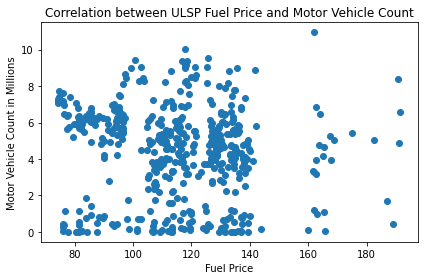

We can't confirm that ulsp fuel price directly affects vehicle count


In [107]:
x_values = [df.select("ulsp_price_litre").collect()]
y_values = [df.select(col("all_motor_vehicles") / 1000000).collect()]
#y_values_millions = [y[0]/1000000 for y in y_values]
plt.scatter(x_values, y_values)
plt.xlabel("Fuel Price")
plt.ylabel("Motor Vehicle Count in Millions")
plt.title("Correlation between ULSP Fuel Price and Motor Vehicle Count")
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()
print("We can't confirm that ulsp fuel price directly affects vehicle count")

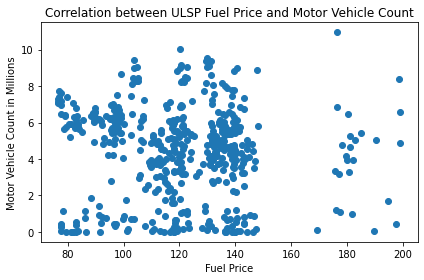

We can't confirm that ulsp fuel price directly affects vehicle count


In [108]:
x_values = [df.select("ulsd_price_litre").collect()]
y_values = [df.select(col("all_motor_vehicles") / 1000000).collect()]
plt.scatter(x_values, y_values)
plt.xlabel("Fuel Price")
plt.ylabel("Motor Vehicle Count in Millions")
plt.title("Correlation between ULSP Fuel Price and Motor Vehicle Count")
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()
print("We can't confirm that ulsp fuel price directly affects vehicle count")